In [1]:
import logging

import numpy as np

def list2array(class_num, dataset_list):
    task_num, worker_num, class_num = len(dataset_list), len(dataset_list[0]), class_num
    dataset_tensor = np.zeros((task_num, worker_num, class_num))

    for task_i in range(task_num): 
        for worker_j in range(worker_num): 
            for predict_label_k in dataset_list[task_i][worker_j]:
                dataset_tensor[task_i][worker_j][predict_label_k] += 1

    return dataset_tensor

class DawidSkeneModel:
    def __init__(self,
                 class_num,
                 max_iter = 100,
                 tolerance = 0.01) -> None:
        self.class_num = class_num
        self.max_iter = max_iter
        self.tolerance = tolerance

    def run(self, dataset):
        self.task_num, self.worker_num, _ = dataset.shape
        self.dataset_tensor = dataset
        predict_label =  self.dataset_tensor.sum(1) / self.dataset_tensor.sum(1).sum(1).reshape(-1, 1)

        flag = True
        prev_error_rates, prev_predict_label = None, None
        iter_num = 0

        while flag:
            error_rates = self._m_step(predict_label)
            next_predict_label = self._e_step(predict_label, error_rates)
            log_L = self._get_likelihood(predict_label, error_rates)

            if iter_num == 0:
                logging.info("{}\t{}".format(iter_num, log_L))
            else:
                marginal_predict = np.sum(predict_label, 0) / self.task_num
                prev_marginal_predict = np.sum(prev_predict_label, 0) / self.task_num
                marginals_diff = np.sum(np.abs(marginal_predict - prev_marginal_predict))
                error_rates_diff = np.sum(np.abs(error_rates - prev_error_rates))

                if self._check_condition(marginals_diff, error_rates_diff, iter_num):
                    flag = False

            prev_error_rates = error_rates
            prev_predict_label = predict_label
            predict_label = next_predict_label
            iter_num += 1

        worker_reliability = {}
        for i in range(self.worker_num):
            ie_rates = marginal_predict * error_rates[i, :, :]
            reliability = np.sum(np.diag(ie_rates))
            worker_reliability[i] = reliability
            
        return marginal_predict, error_rates, worker_reliability, predict_label

    def _check_condition(self, marginals_diff, error_rates_diff, iter_num):
        return (marginals_diff < self.tolerance and error_rates_diff < self.tolerance) or iter_num > self.max_iter

    def _m_step(self, predict_label):
        error_rates = np.zeros((self.worker_num, self.class_num, self.class_num))

        # Equation 2.3
        for i in range(self.class_num):
            worker_error_rate = np.dot(predict_label[:, i], self.dataset_tensor.transpose(1, 0 ,2))
            sum_worker_error_rate = worker_error_rate.sum(1)
            sum_worker_error_rate = np.where(sum_worker_error_rate == 0 , -10e9, sum_worker_error_rate)
            error_rates[:, i, :] = worker_error_rate / sum_worker_error_rate.reshape(-1,1)                                                                        
        return error_rates
    
    def _e_step(self, predict_label, error_rates):
        marginal_probability = predict_label.sum(0) / self.task_num
        next_predict_label = np.zeros([self.task_num, self.class_num])

        # Equation 2.5
        for i in range(self.task_num):
            class_likelood = self._get_class_likelood(error_rates, self.dataset_tensor[i])
            next_predict_label[i] = marginal_probability * class_likelood
            sum_marginal_probability = next_predict_label[i].sum()
            sum_marginal_probability = np.where(sum_marginal_probability == 0 , -10e9, sum_marginal_probability)
            next_predict_label[i] /= sum_marginal_probability
        return next_predict_label

    def _get_likelihood(self, predict_label, error_rates):
        log_L = 0
        marginal_probability = predict_label.sum(0) / self.task_num

        # Equation 2.7
        for i in range(self.task_num):
            class_likelood = self._get_class_likelood(error_rates, self.dataset_tensor[i])
            log_L += np.log((marginal_probability * class_likelood).sum())
        return log_L

    def _get_class_likelood(self, error_rates, task_tensor):
        # \sum_{j=1}^J p_{j} \prod_{k=1}^K \prod_{l=1}^J\left(\pi_{j l}^{(k)}\right)^{n_{il}^{(k)}}
        return np.power(error_rates.transpose(0, 2, 1), np.broadcast_to(task_tensor.reshape(self.worker_num, self.class_num, 1), (self.worker_num, self.class_num, self.class_num))).transpose(1, 2, 0).prod(0).prod(1)

In [2]:
class_num = 4
dataset_list = [
        [[0, 0, 0], [0], [0], [0], [0]],
        [[2, 2, 2], [3], [2], [2], [3]],
        [[0, 0, 1], [1], [0], [1], [1]],
        [[1, 1, 1], [2], [0], [1], [0]],
        [[1, 1, 1], [2], [1], [1], [1]],
        [[1, 1, 1], [2], [2], [1], [1]],
        [[0, 1, 1], [1], [0], [0], [0]],
        [[2, 2, 2], [2], [3], [2], [2]],
        [[1, 1, 1], [1], [1], [1], [2]],
        [[1, 2, 1], [1], [1], [1], [2]],
        [[3, 3, 3], [3], [3], [3], [3]],
        [[1, 1, 1], [2], [2], [3], [2]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[1, 1, 1], [2], [1], [0], [1]],
        [[0, 1, 0], [0], [0], [0], [0]],
        [[0, 0, 0], [1], [0], [0], [0]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[1, 1, 1], [1], [1], [1], [0]],
        [[1, 1, 1], [0], [2], [1], [1]],
        [[1, 1, 1], [1], [1], [1], [1]],
        [[1, 1, 1], [1], [1], [1], [0]],
        [[1, 1, 1], [2], [1], [1], [1]],
        [[1, 1, 0], [1], [1], [1], [1]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[1, 2, 1], [1], [1], [1], [1]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[0, 0, 1], [0], [0], [1], [0]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[2, 2, 2], [2], [1], [2], [2]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[1, 1, 1], [1], [1], [1], [1]],
        [[1, 1, 1], [2], [1], [2], [1]],
        [[3, 2, 2], [3], [2], [3], [2]],
        [[1, 1, 0], [1], [1], [2], [1]],
        [[1, 2, 1], [2], [1], [2], [2]],
        [[2, 2, 2], [2], [3], [2], [1]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[0, 0, 0], [0], [0], [0], [0]],
        [[0, 1, 0], [1], [0], [0], [0]],
        [[1, 2, 1], [1], [1], [1], [1]],
        [[0, 1, 0], [0], [0], [0], [0]],
        [[1, 1, 1], [1], [1], [1], [1]]
]


In [4]:
dataset_tensor = list2array(class_num, dataset_list)
model = DawidSkeneModel(class_num, max_iter=45, tolerance=10e-100)
marginal_predict, error_rates, worker_reliability, predict_label = model.run(dataset_tensor)

In [17]:
error_rates[0]

array([[0.88948835, 0.11051165, 0.        , 0.        ],
       [0.07058545, 0.87637994, 0.05303461, 0.        ],
       [0.        , 0.33882154, 0.66117846, 0.        ],
       [0.        , 0.        , 0.55555556, 0.44444444]])

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

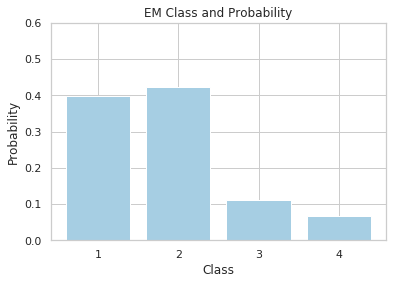

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x_position = np.arange(len(marginal_predict))
ax.bar(x_position, marginal_predict,  tick_label=[1, 2, 3, 4], error_kw=error_bar_set)

# df_melt = pd.melt(df)
# df_melt_little = pd.concat([df_melt[df_melt["variable"] == i].head(100) for i in range(4)])

# sns.stripplot(x='variable', y='value', data=df_melt_little, jitter=1, color='black', ax = ax)

ax.set_title('EM Class and Probability')
ax.set_xlabel('Class')
ax.set_ylabel('Probability')
ax.set_ylim(0, 0.6)
plt.show()

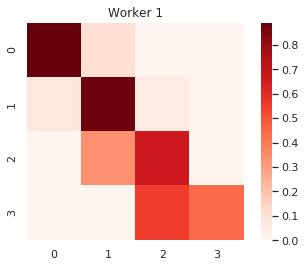

In [18]:
ax = plt.axes()
ax.set_title('Worker 1')
sns.heatmap(error_rates[0], cmap="Reds", square=True, ax=ax);
plt.show()

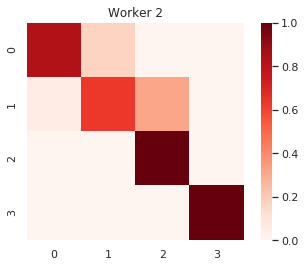

In [19]:
ax = plt.axes()
ax.set_title('Worker 2')
sns.heatmap(error_rates[1], cmap="Reds", square=True, ax=ax);
plt.show()

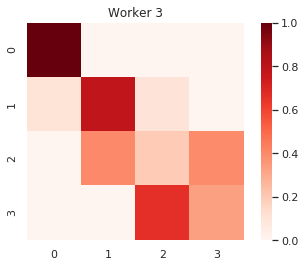

In [20]:
ax = plt.axes()
ax.set_title('Worker 3')
sns.heatmap(error_rates[2], cmap="Reds", square=True, ax=ax);
plt.show()

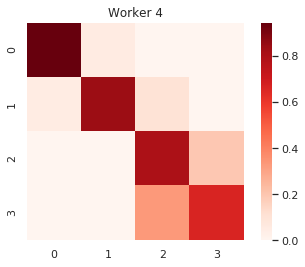

In [21]:
ax = plt.axes()
ax.set_title('Worker 4')
sns.heatmap(error_rates[3], cmap="Reds", square=True, ax=ax);
plt.show()

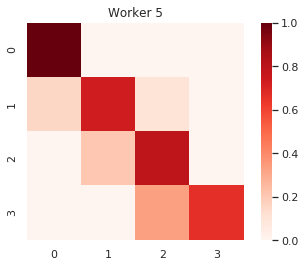

In [22]:
ax = plt.axes()
ax.set_title('Worker 5')
sns.heatmap(error_rates[4], cmap="Reds", square=True, ax=ax);
plt.show()